## Basic, time-domain, correlation based beamforming

In [1]:
# Python 3.7

import sys
sys.path.append('../GI1_v0.2.1')
sys.path.append('../GI1_v0.2.1/PLOT/')
sys.path.append('../GI1_additions')


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import green as g
import source as s
import processing as proc
import parameters
import time
import random
from correlation_random import *
from correlation_function import *
from correlation_field import *
from kernels import *
from adsrc import *
from earthquakes import *

# The following are newly added, as compared to the original GI code.
from generate_random_signals import *
from specshift import *

%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = [20, 10]

In [3]:
## Check the station and noise-source geometry
# S,indeces=s.space_distribution(plot=1)

In [5]:
use_saved_data = True

#####################################################
if(use_saved_data is False):
    
    # Check the station and noise-source geometry
    S,indeces=s.space_distribution(plot=1)


    # Re-create the synthetic data.
    ut,traw,cct,t,ccf,f = generate_random_signals(verbose=False,plot=True,save=True,return_cc=True)
#####################################################
else:
    # Alternatively, just load from file
    p=parameters.Parameters()

    # Load "traw" of raw timeseries
    filename = './OUTPUT/raw_synthetics/traw.npy'
    traw = np.load(filename)
    
    # Load raw timeseries
    for i in range(p.Nreceivers):
        filename = './OUTPUT/raw_synthetics/syn_{0}.npy'.format(i)
        if(i==0): # first one, load to get size.
            tmp = np.load(filename)
            [nsamp,nwindows] = np.shape(tmp)
            ut = np.zeros([nsamp,nwindows,p.Nreceivers])
            ut[:,:,i] = tmp
        else:
            ut[:,:,i] = np.load(filename)
    
    # Load "t" of correlations functions
    filename = './OUTPUT/correlations_measured/t.npy'
    tt_corr = np.load(filename)
    nt = np.size(tt_corr)

    # Load correlation functions
    cct = np.zeros([nt,p.Nwindows,p.Nreceivers**2])
    counter = 0
    for i in range(p.Nreceivers):
        for j in range(p.Nreceivers):        
            filename = "./OUTPUT/correlations_measured/cct_proc_{}_{}.npy".format(i,j)
            this_corr = np.load(filename)

            cct[:,:,counter] = this_corr
            counter += 1
#####################################################


## A quick back-of-the-envelope check of our array dimensions.
### The bandpass filter of our data should be comparable to the wavelengths/frequencies resolveable by the array aperature and station-spacing.

### In general, beamforming can be used on data that with shorter or longer periods than described here. In the case of shorter periods (high frequency), expect aliasing. In the case of longer periods (low frequency), expect a large "blob" or poor resolution.

### The array-response function (not shown here) can be useful to characterize an array, and potentially even deconvolved from the resulting image.

In [6]:
## A quick back-of-the-envelope check of our array dimensions.
## The bandpass filter of our data should be comparable to the 
##  wavelengths/frequencies resolveable by the array aperature 
##  and station-spacing.


xx = p.x/1000
yy = p.y/1000
dis=[]
for i in range(p.Nreceivers):
    for j in range(p.Nreceivers):
        if(i==j):
            continue
        dis.append( np.sqrt( (xx[i]-xx[j])**2 + (yy[i]-yy[j])**2 ))
print("Average distance = {0:.2f}km".format(np.mean(dis)))
print("At 3km/s, average period for array = {0:.2f}sec".format(np.mean(dis)/3))
print("")

print("Min distance (inter-station) = {0:.2f}km".format(np.min(dis)))
print("At 3km/s, shortest period = {0:.2f}sec".format(np.min(dis)/3))
print("")


print("Max distance (aperture) = {0:.2f}km".format(np.max(dis)))
print("At 3km/s, longest period = {0:.2f}sec".format(np.max(dis)/3))
print("")


print("Signals bandpassed from {0:.2f} to {1:.2f} Hz, {2:.2f} to {3:.2f} seconds".format(p.bp_fmin,p.bp_fmax,1/p.bp_fmax,1/p.bp_fmin))

## In general, beamforming can be used on data that with shorter or longer periods than described here.
##  In the case of shorter periods (high frequency), expect aliasing.
##  In the case of longer periods (low frequency), expect a large "blob" or poor resolution.
## 
## The array-response function (not shown here) can be useful to characterize an array, and potentially even
##  deconvolved from the resulting image.

Average distance = 6.06km
At 3km/s, average period for array = 2.02sec

Min distance (inter-station) = 1.95km
At 3km/s, shortest period = 0.65sec

Max distance (aperture) = 12.33km
At 3km/s, longest period = 4.11sec

Signals bandpassed from 0.30 to 5.70 Hz, 0.18 to 3.33 seconds


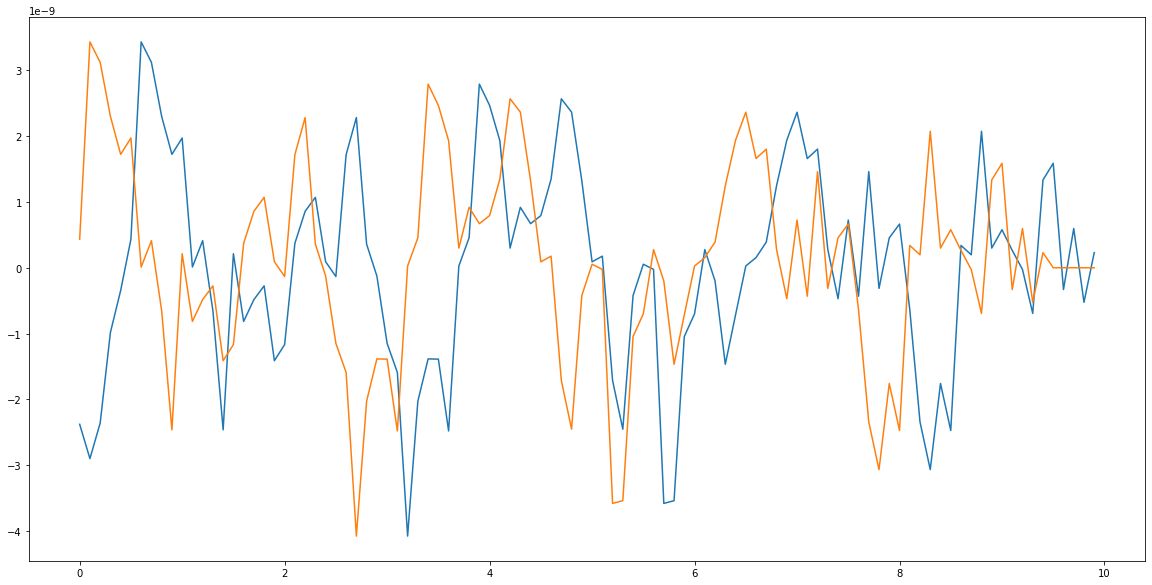

In [7]:
## We use a function "specshift" for time-shifts. 
## Check that the function is working:

# Pull a 100-sample chunk out for testing
# 0-th time-window / realisation
# Two stations (0:1)
data = ut[:100,0,0:1]
tt = traw[:100]

dt = traw[1]-traw[0]
# We'll apply a 0.5-second shift
shifts = [0.5]/dt
plt.plot(tt,data)

data_shifted = specshift(data,shifts)
plt.plot(tt,data_shifted)

plt.show()

In [ ]:
# Beamform!!

            
# "Data" will consist of raw timeseries from just the first time window (only one by default)
iwin=0
data=ut[:,iwin,:]


# This uses time domain shifts. This is rather slow, because it uses the fft-domain,
#  specshift function. This could be simplified or made faster with direct shifts.
#  Also, probably most production-quality beamform codes operate in frequency domain anyways.

#- Input parameters.
p=parameters.Parameters()



# Define a grid of slownesses to test
# TODO - load this from parameters instead of hardcode?
# max-slowness:
sl=.75 # second/km

# (green's functions programmed at 3000m/s -> 0.33s/km)
# number of pixes in x and y
# nux = 101
# nuy = 101
nux = 101
nuy = 101
ux = np.linspace(-sl,sl,nux)
uy = np.linspace(-sl,sl,nuy)
dux=ux[1]-ux[0]
duy=uy[1]-uy[0]

# Define the index of actual noise source, for verification
# (as defined in source.py)
expected_slowness = 1/3.0
sx = expected_slowness*np.sqrt(2)/2
sy = expected_slowness*np.sqrt(2)/2
ix0=(np.abs(ux-sx)).argmin()
iy0=(np.abs(uy-sy)).argmin()

# For each pixel in slowness space, construct a library of travel times to each station
# (This script assumes station x and y are defined as km away from an origin.
#  if x and y are lon/lat, will need to modify)
tlib=np.zeros([p.Nreceivers,nux,nuy],dtype=float)
nsta = np.shape(ut)[2]
P=np.zeros([nux,nuy])

xx = p.x/1000
yy = p.y/1000

counter_grid = 0
print("starting gridpoints: {0}".format(nux*nuy))
for ix in range(0,nux):
        for iy in range(0,nuy):
                counter_grid+=1
                if(counter_grid % 10 == 0):
                    print(counter_grid)
                 
  
                for i in range(nsta):
                    for j in range(nsta):
                        if(i==j):
                            continue
                        timeshift = (xx[i]-xx[j])*ux[ix] + (yy[i]-yy[j])*uy[iy]
                        d1 = specshift(data[:,i],-timeshift/dt)
                        d2 = np.reshape(data[:,j],[16384,1])
                        C = np.corrcoef(d1.T,d2.T) # C will be a 2x2 array
                        P[ix,iy] += C[0,1]

                #- The 5 lines below offer a more computationally efficient alternative
                #- Rather than loop through every station pair, define a common centerpoint
                #-  and shift everything at once.
                #-
                # timeshifts = xx*ux[ix] + yy*uy[iy]
                # dshift = specshift(data,-timeshifts/dt)
                # A = np.corrcoef(dshift.T)
                # np.fill_diagonal(A,0) # Exclude autocorrelations
                # P[ix,iy] = np.sum( A )/np.size(A)


np.save('1_P', P)
# Now go to "plot_saved_maps"

starting gridpoints: 10201
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470


## Plotting

### First, on a square grid

In [ ]:
mpl.rc('font', **{'size':20})

def plot_beam(P, title="Beamform",save=0,savename='none',cmax=0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.6,0.6])  #x0,y0,dx,dy
    cmap = plt.get_cmap('inferno')
    i = plt.pcolor(ux-dux/2,uy-duy/2,np.real(P.T),cmap=cmap,rasterized=True)#,vmin=-4,vmax=4)
    if(cmax==0):
        cmax=np.max(np.abs(P))
    cmin=np.min(P)
    plt.clim(cmin, cmax)
    
    plt.axis('equal')
    plt.axis('tight')
    plt.xlim(min(ux)+dux,max(ux)-dux)
    plt.ylim(min(uy)+duy,max(uy)-duy)
    plt.xlabel('Slowness East-West [s/km]')
    plt.ylabel('Slowness North-South [s/km]')
    ax.tick_params(top=True,right=True)
    plt.plot(sx,sy,'k*')
    plt.plot([np.min(ux), np.max(ux)],[0,0],'k')
    plt.plot([0,0],[np.min(uy), np.max(uy)],'k')
    plt.title(title)
    colorbar_ax = fig.add_axes([0.75, 0.1, 0.03, 0.6])  #x0,y0,dx,dy
    fig.colorbar(i, cax=colorbar_ax)
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    plt.show()



plot_beam(P, title="Beamform", 
          save=False, savename="1_standard_beamform_square")
plot_beam(P2, title="Beamform", 
          save=False, savename="1_standard_beamform_square")

### Now, transform to polar axis and plot on a circular grid.
### We find this is somewhat more intuitive for readers; it is easier to understand that this is pointing out towards different directions when it looks like a compass. 
### Note - a better algorithm might define the slowness domain on polar coordinates from the very beginning. This would require reorganizing the for-loops in the algorithm above, to loop through values of theta and r. 

In [ ]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

UX, UY = np.meshgrid(ux, uy)
UR = np.zeros_like(UX)
UT = np.zeros_like(UY)
for iux in range(nux):
    for iuy in range(nuy):
#         UR[iux, iuy], UT[iux, iuy] = cart2pol(UX[iux, iuy], UY[iux, iuy])
        UR[iux, iuy], UT[iux, iuy] = cart2pol(UX[iux, iuy]-dux/2, UY[iux, iuy]-duy/2)
        
SR, ST = cart2pol(sx, sy)


In [ ]:
mpl.rc('font', **{'size':20})
    
def plot_beam_polar(P, title="Beamform",save=0,savename='none',cmax=0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, polar = True)
    cmap = plt.get_cmap('inferno')
    i = plt.pcolor(2*np.pi-UT[::1]+np.pi/2, UR[::1], np.real(P[::1]), cmap=cmap, rasterized=True)
    
    if(cmax==0):
        cmax=np.max(np.abs(P))
    cmin=np.min(P)
    plt.clim(cmin, cmax)
    
    # set title, labels, etc
    plt.title(title)
    
    ax.set_xticks(np.arange(0, 2.0*np.pi, np.pi/2.0))
    ax.set_xticklabels(["E", "N", "W", "S"])
    ax.tick_params(axis='x', colors='black', grid_linestyle='--')
    
    ax.set_ylim(0,0.5)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4])
    ax.tick_params(axis='y', colors='white', grid_linestyle='--')
    ax.text(np.radians(-10), 0.15, 'Slowness [s/km]', rotation=0, color="white")
    ax.set_rlabel_position(0)
    ax.grid(True)
    
    # plot expected blob
    plt.plot(ST, SR, 'k*', markersize=11)

    # colorbar
    colorbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])  #x0,y0,dx,dy
    fig.colorbar(i, cax=colorbar_ax)
    
    # save figure
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    plt.show()


plot_beam_polar(P,title="Standard Beamform: timeshift, then correlate", save=1, savename="1_standard_beamform_polar.pdf")
